In [1]:
import os
from typing import Optional, Tuple
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import calendar

In [2]:
# Load the datasets using the read_csv() method. You can specify the separator used in the csv file. By default, the separator is ","
products_df = pd.read_csv('product_inf_2000.csv')
client_df = pd.read_csv('client_inf_2000.csv',sep=';')
transactions_df = pd.read_csv('transac_inf_2000.csv', sep=',')

In [3]:
products = pd.read_csv('product(1).csv')
client = pd.read_csv('client(1).csv', sep=';')
transactions = pd.read_csv('transac(1).csv', sep=';')

In [4]:
# Concaténation des DataFrames
combined_products = pd.concat([products, products_df], ignore_index=True)

# Harmonisation des types de colonnes selon le plus grand DataFrame
for col in products_df.columns:
    combined_products[col] = combined_products[col].astype(products_df[col].dtype)

# Vérification des informations du DataFrame combiné
print(combined_products.info())

# Optionnel : sauvegarde en CSV
combined_products.to_csv('combined_products.csv', index=False, sep=',', na_rep='')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       9988 non-null   object 
 1   gender           9988 non-null   object 
 2   sku_description  9907 non-null   object 
 3   marketing_color  9889 non-null   object 
 4   main_material    7524 non-null   object 
 5   universe         9988 non-null   object 
 6   macro_family     9988 non-null   object 
 7   function         9988 non-null   object 
 8   price_fr_eur     9988 non-null   float64
 9   collection       9762 non-null   object 
 10  aesthetic_line   7468 non-null   object 
dtypes: float64(1), object(10)
memory usage: 858.5+ KB
None


In [5]:
# Concaténation des DataFrames
combined_client = pd.concat([client, client_df], ignore_index=True)

# Harmonisation des types de colonnes selon client_df (le plus grand DataFrame)
for col in client_df.columns:
    combined_client[col] = combined_client[col].astype(client_df[col].dtype)

# Vérification des informations du DataFrame combiné
print(combined_client.info())

# Optionnel : sauvegarde en CSV
combined_client.to_csv('combined_client.csv', index=False, sep=',', na_rep='')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421278 entries, 0 to 421277
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   week              421278 non-null  object
 1   nationality       421278 non-null  object
 2   gender            421278 non-null  object
 3   universe          421278 non-null  object
 4   macro_family      421278 non-null  object
 5   is_reachable      421278 non-null  int64 
 6   age               421278 non-null  object
 7   is_big_client     421278 non-null  bool  
 8   store_type_label  421278 non-null  object
 9   store_zone        421278 non-null  object
 10  clients           421278 non-null  int64 
 11  items_bought      421278 non-null  int64 
dtypes: bool(1), int64(3), object(8)
memory usage: 35.8+ MB
None


In [6]:
# Renommer la colonne 'website_version' en 'country' pour uniformiser
transactions_df = transactions_df.rename(columns={'website_version': 'country'})

# Concaténation
combined_transactions = pd.concat([transactions, transactions_df], ignore_index=True)

# Harmonisation des types selon transactions_df
for col in transactions_df.columns:
    combined_transactions[col] = combined_transactions[col].astype(transactions_df[col].dtype)

# Vérification
print(combined_transactions.info())

# Optionnel : sauvegarde en CSV
combined_transactions.to_csv('combined_transactions.csv', index=False, sep=',', na_rep='')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840598 entries, 0 to 5840597
Data columns (total 6 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   week                        object
 1   product_id                  object
 2   store_type_label            object
 3   country                     object
 4   count_distinct_transaction  int64 
 5   product_quantity            int64 
dtypes: int64(2), object(4)
memory usage: 267.4+ MB
None


In [7]:
def get_month_and_year(week_string):
    # Extract the year and week number from the input string
    year_str = week_string[1:5]
    week_num_str = week_string[5:]

    # Convert the year and week number to integers
    year = int(year_str)
    week_num = int(week_num_str)

    # Extract the month and year of every day of the week and chose the average month and year
    months, years = [], []
    try:
            # Handle week 0 (January of the given year)
            if week_num == 0:
                day = datetime.date.fromisocalendar(year, 1, 1)  # First day of the year
                months.append(day.month)
                years.append(day.year)
    
            # Handle valid week numbers (1 to 52, or 53 if valid)
            else:
                for i in range(1, 8):  # Iterate over the days of the week
                    day = datetime.date.fromisocalendar(year, week_num, i)
                    months.append(day.month)
                    years.append(day.year)
    
    except ValueError:
            # Handle invalid week numbers (like non-existent week 53)
            last_day_of_year = datetime.date(year, 12, 31)
            months.append(last_day_of_year.month)
            years.append(last_day_of_year.year)
        
    average_month = Counter(months).most_common(1)[0][0]
    average_year = Counter(years).most_common(1)[0][0]

    # Convert the month to the corresponding label
    month = calendar.month_name[average_month]

    return month[:3] + '-' + str(average_year)

#Example
week_string = "W202148"
print(get_month_and_year(week_string))

Dec-2021


In [8]:
combined_client['week'] = combined_client['week'].apply(get_month_and_year)
combined_client.head(2)

,week,nationality,gender,universe,macro_family,is_reachable,age,is_big_client,store_type_label,store_zone,clients,items_bought
0,Mar-2023,Chinese,Men,LEATHER GOODS,CITY BAGS,1,"[24,35[",False,Web,MAINLAND CHINA,256,271
1,Aug-2024,Chinese,Men,LEATHER GOODS,CITY BAGS,1,"[24,35[",False,Physical Store,MAINLAND CHINA,256,305


In [9]:
combined_transactions['week'] = combined_transactions['week'].apply(get_month_and_year)
combined_transactions.head(2)

,week,product_id,store_type_label,country,count_distinct_transaction,product_quantity
0,Oct-2023,M45773,Physical Store,GUAM,2,3
1,Aug-2024,M46203,Physical Store,GUAM,2,4


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



C:\Users\gabyd\AppData\Local\Temp\ipykernel_7728\2648078512.py:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=sales_by_store,


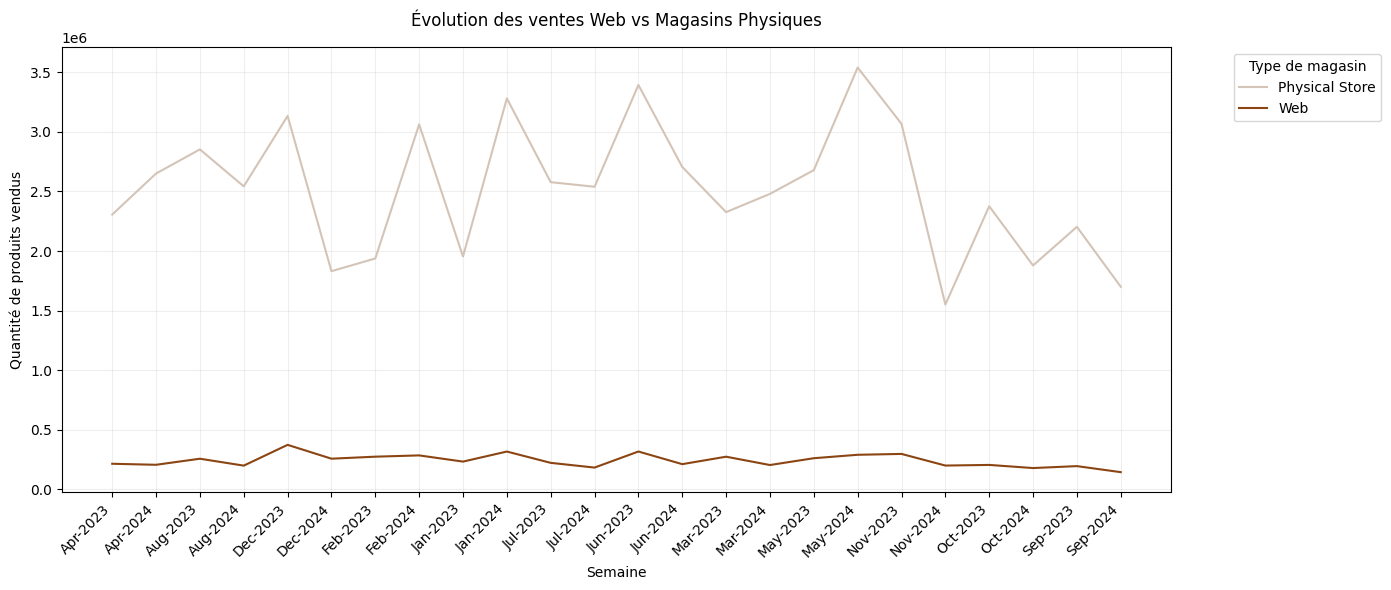

In [16]:
colors = ['#D4C4B7',    # beige
          '#8B4513',    # saddle brown
          '#2F1810']    # dark brown/black

sales_by_store = combined_transactions.groupby(['week', 'store_type_label'])['product_quantity'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_by_store, 
            x='week', 
            y='product_quantity', 
            hue='store_type_label',
            palette=colors)

plt.title('Évolution des ventes Web vs Magasins Physiques', fontsize=12, pad=15)
plt.xlabel('Semaine', fontsize=10)
plt.ylabel('Quantité de produits vendus', fontsize=10)

# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')  # ha='right' aligns the rotated labels

plt.legend(title='Type de magasin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

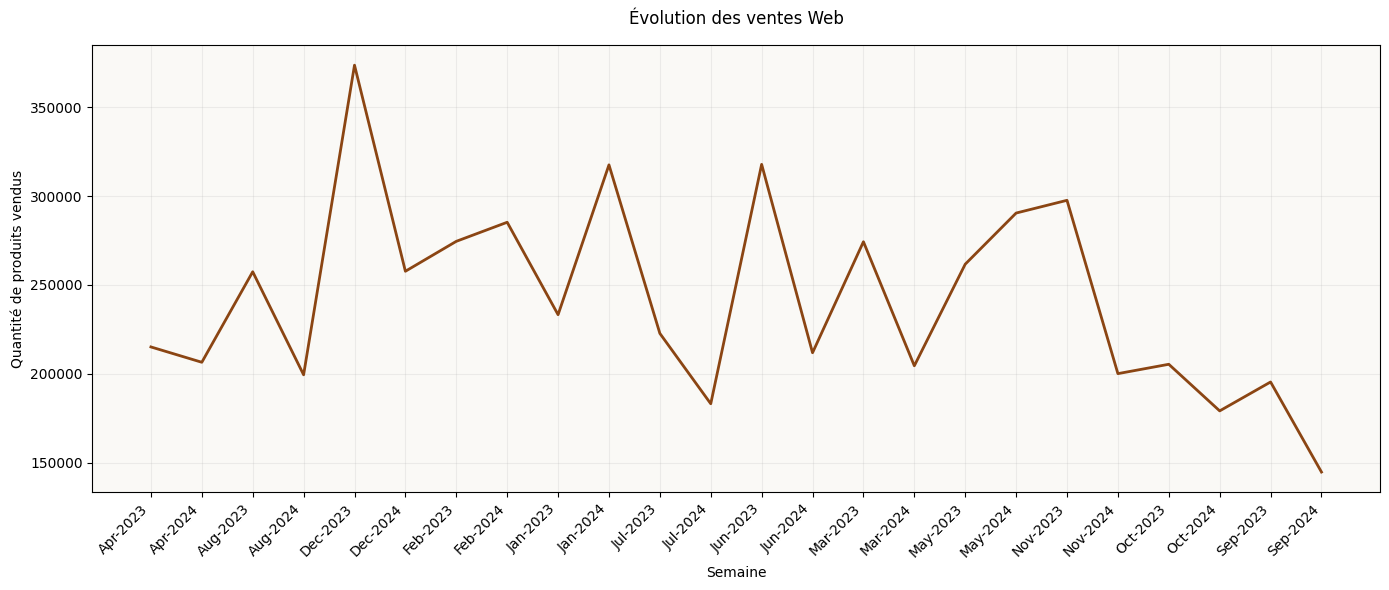

In [18]:
# First, create a mask for Web sales
web_sales = combined_transactions[combined_transactions['store_type_label'] == 'Web']

# Group by week for Web sales
sales_by_store = web_sales.groupby('week')['product_quantity'].sum().reset_index()

# Create the visualization
colors = ['#8B4513']    # Using brown for web sales

plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_by_store, 
            x='week', 
            y='product_quantity',
            color=colors[0],
            linewidth=2)

plt.title('Évolution des ventes Web', fontsize=12, pad=15)
plt.xlabel('Semaine', fontsize=10)
plt.ylabel('Quantité de produits vendus', fontsize=10)
plt.xticks(rotation=45, ha='right')

plt.grid(True, alpha=0.2)
plt.gca().set_facecolor('#FAF9F6') 

plt.tight_layout()
plt.show()

In [19]:
# clustering_models.py
class ClusteringModel:
    def __init__(self):
        self.scaler = StandardScaler()
    
    def prepare_clustering_data(self, combined_client, combined_transactions, combined_products):
    
    # Agrégation des transactions par client
        client_purchase_history = combined_transactions.groupby('week').agg({
        'count_distinct_transaction': 'sum',
        'product_quantity': 'sum'
        }).reset_index()
    
    # Calcul des variables pour le clustering
        client_features = pd.DataFrame()
        client_features['total_transactions'] = combined_client.groupby('clients')['items_bought'].sum()
        client_features['frequency'] = combined_client.groupby('clients')['week'].nunique()
    
    # Gestion des valeurs manquantes
        client_features = client_features.fillna(0)
    
    # Standardisation des features
        features_scaled = self.scaler.fit_transform(client_features)
        return pd.DataFrame(features_scaled, columns=client_features.columns)

    def visualize_clusters(self, data, clusters, method='kmeans'):
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters, cmap='viridis')
        plt.title(f'Visualisation des clusters ({method})')
        plt.colorbar(scatter)
        plt.show()

In [30]:
# kmeans_model.py
class KMeansModel(ClusteringModel):
    def __init__(self):
        super().__init__()
        self.kmeans = None
        
    def cluster(self, data, n_clusters=3):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        clusters = self.kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, clusters)
        print(f"Score silhouette K-means: {silhouette_avg}")
        
        return clusters

In [31]:
class DBSCANModel(ClusteringModel):
    def __init__(self):
        super().__init__()
        self.dbscan = None
    
    def cluster(self, data, eps=0.3, min_samples=3): 
    
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = self.dbscan.fit_predict(data)
        
        n_clusters = len(set(clusters[clusters != -1]))
        
        print(f"Number of clusters found: {n_clusters}")
        print(f"Number of noise points: {sum(clusters == -1)}")
        
        mask = clusters != -1
        if n_clusters >= 2 and mask.any():
            try:
                silhouette_avg = silhouette_score(data[mask], clusters[mask])
                print(f"Score silhouette DBSCAN: {silhouette_avg}")
            except Exception as e:
                print(f"Could not calculate silhouette score: {str(e)}")
        else:
            print("Not enough clusters found for silhouette score calculation")
            if eps > 0.1:
                print("Attempting with smaller eps...")
                return self.cluster(data, eps=eps/2, min_samples=min_samples)
        
        return clusters

In [20]:
combined_transactions.head(2)

,week,product_id,store_type_label,country,count_distinct_transaction,product_quantity
0,Oct-2023,M45773,Physical Store,GUAM,2,3
1,Aug-2024,M46203,Physical Store,GUAM,2,4


In [38]:
summary_data_from_transaction_data(combined_transactions,  'week', 'product_quantity').head(2)

,frequency,recency,T
week,,,
Apr-2023,0.0,0.0,0.0
Apr-2024,0.0,0.0,0.0


In [32]:
# clv_models.py
class CLVModel:
    def prepare_clv_data(self, combined_transactions):
        return summary_data_from_transaction_data(
            combined_transactions,
            'clients',
            'week',
            'product_quantity',
            'count_distinct_transaction'
        )

    def visualize_clv_distribution(self, predicted_clv):
        plt.figure(figsize=(10, 6))
        sns.histplot(predicted_clv, bins=50)
        plt.title('Distribution des CLV prédits')
        plt.xlabel('CLV prédit')
        plt.ylabel('Fréquence')
        plt.show()

In [24]:
# bgnbd_model.py
class BGNBDModel(CLVModel):
    def __init__(self):
        self.bgf = None
        
    def fit(self, summary_data):
        self.bgf = BetaGeoFitter(penalizer_coef=0.0)
        self.bgf.fit(
            summary_data['frequency'],
            summary_data['recency'],
            summary_data['T']
        )
        
        predicted_purchases = self.bgf.predict(
            summary_data['frequency'],
            summary_data['recency'],
            summary_data['T'],
            30
        )
        mse = np.mean((predicted_purchases - summary_data['frequency']) ** 2)
        print(f"MSE du modèle BG/NBD: {mse}")
        
        return predicted_purchases

In [33]:
import numpy as np
# gamma_gamma_model.py
class GammaGammaModel(CLVModel):
    def __init__(self):
        self.ggf = None
        
    def fit(self, summary_data):
        self.ggf = GammaGammaFitter(penalizer_coef=0.0)
        self.ggf.fit(
            summary_data['frequency'],
            summary_data['monetary_value']
        )
        
        predicted_clv = self.ggf.conditional_expected_average_profit(
            summary_data['frequency'],
            summary_data['monetary_value']
        )
        mse = np.mean((predicted_clv - summary_data['monetary_value']) ** 2)
        print(f"MSE du modèle Gamma-Gamma: {mse}")
        
        return predicted_clv

Score silhouette K-means: 0.8168695437752055


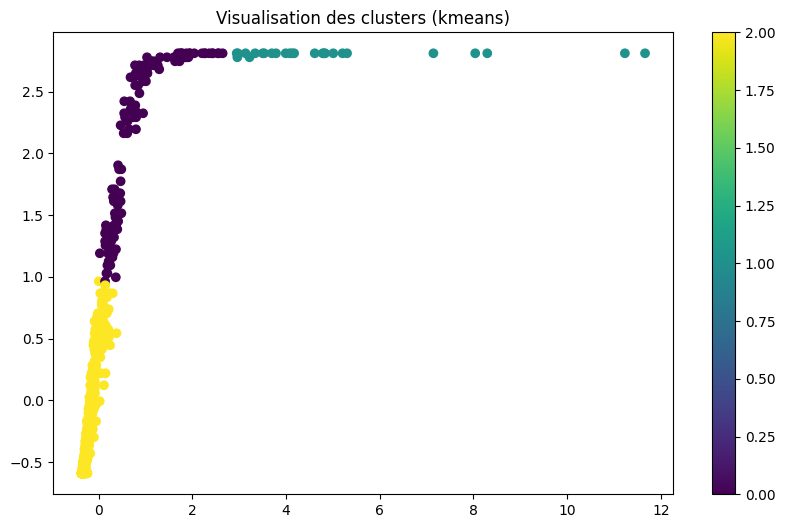

Number of clusters found: 3
Number of noise points: 5
Score silhouette DBSCAN: 0.7707447902511183


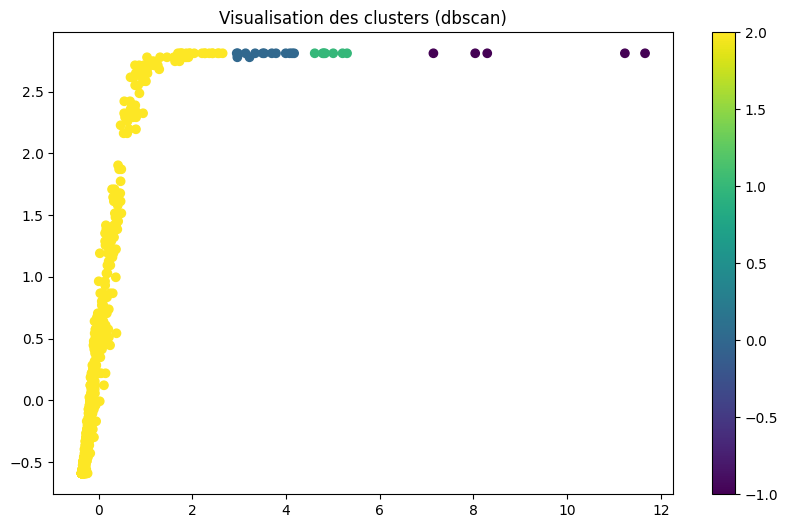

ValueError: time data "W202452" doesn't match format "count_distinct_transaction", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [34]:
# main.py
def main():
    # Chargement des données
    client_data = pd.read_csv('combined_client.csv')
    transaction_data = pd.read_csv('combined_transactions.csv')
    product_data = pd.read_csv('combined_products.csv')
    
    # Clustering avec KMeans
    kmeans = KMeansModel()
    clustering_data = kmeans.prepare_clustering_data(client_data, transaction_data, product_data)
    kmeans_clusters = kmeans.cluster(clustering_data)
    kmeans.visualize_clusters(clustering_data, kmeans_clusters, 'kmeans')
    
    # Clustering avec DBSCAN
    dbscan = DBSCANModel()
    dbscan_clusters = dbscan.cluster(clustering_data)
    dbscan.visualize_clusters(clustering_data, dbscan_clusters, 'dbscan')
    
    # Analyse CLV avec BG/NBD
    bgnbd = BGNBDModel()
    clv_data = bgnbd.prepare_clv_data(transaction_data)
    predicted_frequency = bgnbd.fit(clv_data)
    
    # Analyse CLV avec Gamma-Gamma
    gamma = GammaGammaModel()
    predicted_clv = gamma.fit(clv_data)
    gamma.visualize_clv_distribution(predicted_clv)

if __name__ == "__main__":
    main()